In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import deepchem as dc
from tqdm import tqdm_notebook
from scipy.spatial.distance import norm

from fastai.tabular import *
from fastai.callbacks import SaveModelCallback
from fastai.basic_data import DataBunch

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

In [2]:
DATA_PATH = '../data/'
PATH = '../tmp'

In [3]:
files = os.listdir(DATA_PATH)
files = [f for f in files if f.find('.csv') != -1]
files

['scalar_coupling_contributions.csv',
 'mulliken_charges.csv',
 'structures.csv',
 'test.csv',
 'train.csv',
 'magnetic_shielding_tensors.csv',
 'dipole_moments.csv',
 'sample_submission.csv',
 'potential_energy.csv']

In [4]:
train_df = pd.read_csv(DATA_PATH+'train.csv')
test_df = pd.read_csv(DATA_PATH+'test.csv')
structures_df = pd.read_csv(DATA_PATH+'structures.csv')

In [5]:
%%time
atoms_per_molecule_df = structures_df.groupby(['molecule_name', 'atom']).count()
atoms_per_molecule_map = atoms_per_molecule_df['atom_index'].unstack().fillna(0).astype(int).to_dict()

CPU times: user 2.24 s, sys: 127 ms, total: 2.37 s
Wall time: 692 ms


In [6]:
%%time
pd.options.mode.chained_assignment = None
atoms = structures_df['atom'].unique()
train_df['num_atoms'] = 0
test_df['num_atoms'] = 0
for atom in atoms:
    train_df[f'num_{atom}_atoms'] = train_df['molecule_name'].map(atoms_per_molecule_map[atom])
    train_df['num_atoms'] += train_df[f'num_{atom}_atoms']
    test_df[f'num_{atom}_atoms'] = test_df['molecule_name'].map(atoms_per_molecule_map[atom])
    test_df['num_atoms'] += test_df[f'num_{atom}_atoms']

CPU times: user 15.2 s, sys: 900 ms, total: 16.1 s
Wall time: 5.42 s


In [7]:
train_df.columns

Index(['id', 'molecule_name', 'atom_index_0', 'atom_index_1', 'type',
       'scalar_coupling_constant', 'num_atoms', 'num_C_atoms', 'num_H_atoms',
       'num_N_atoms', 'num_O_atoms', 'num_F_atoms'],
      dtype='object')

## Get Molecules

In [8]:
##
# Written by Jan H. Jensen based on this paper Yeonjoon Kim and Woo Youn Kim 
# "Universal Structure Conversion Method for Organic Molecules: From Atomic Connectivity
# to Three-Dimensional Geometry" Bull. Korean Chem. Soc. 2015, Vol. 36, 1769-1777 DOI: 10.1002/bkcs.10334
#
from rdkit import Chem
from rdkit.Chem import AllChem
import itertools
from rdkit.Chem import rdmolops
from collections import defaultdict
import copy
import networkx as nx #uncomment if you don't want to use "quick"/install networkx


global __ATOM_LIST__
__ATOM_LIST__ = [ x.strip() for x in ['h ','he', \
      'li','be','b ','c ','n ','o ','f ','ne', \
      'na','mg','al','si','p ','s ','cl','ar', \
      'k ','ca','sc','ti','v ','cr','mn','fe','co','ni','cu', \
      'zn','ga','ge','as','se','br','kr', \
      'rb','sr','y ','zr','nb','mo','tc','ru','rh','pd','ag', \
      'cd','in','sn','sb','te','i ','xe', \
      'cs','ba','la','ce','pr','nd','pm','sm','eu','gd','tb','dy', \
      'ho','er','tm','yb','lu','hf','ta','w ','re','os','ir','pt', \
      'au','hg','tl','pb','bi','po','at','rn', \
      'fr','ra','ac','th','pa','u ','np','pu'] ]


def get_atom(atom):
    global __ATOM_LIST__
    atom = atom.lower()
    return __ATOM_LIST__.index(atom) + 1


def getUA(maxValence_list, valence_list):
    UA = []
    DU = []
    for i, (maxValence,valence) in enumerate(zip(maxValence_list, valence_list)):
        if maxValence - valence > 0:
            UA.append(i)
            DU.append(maxValence - valence)
    return UA,DU


def get_BO(AC,UA,DU,valences,UA_pairs,quick):
    BO = AC.copy()
    DU_save = []

    while DU_save != DU:
        for i,j in UA_pairs:
            BO[i,j] += 1
            BO[j,i] += 1 
        
        BO_valence = list(BO.sum(axis=1))
        DU_save = copy.copy(DU)
        UA, DU = getUA(valences, BO_valence)
        UA_pairs = get_UA_pairs(UA,AC,quick)[0]

    return BO


def valences_not_too_large(BO,valences):
    number_of_bonds_list = BO.sum(axis=1)
    for valence, number_of_bonds in zip(valences,number_of_bonds_list):
        if number_of_bonds > valence:
            return False

    return True


def BO_is_OK(BO,AC,charge,DU,atomic_valence_electrons,atomicNumList,charged_fragments):
    Q = 0 # total charge
    q_list = []
    if charged_fragments:
        BO_valences = list(BO.sum(axis=1))
        for i,atom in enumerate(atomicNumList):
            q = get_atomic_charge(atom,atomic_valence_electrons[atom],BO_valences[i])
            Q += q
            if atom == 6:
                number_of_single_bonds_to_C = list(BO[i,:]).count(1)
                if number_of_single_bonds_to_C == 2 and BO_valences[i] == 2:
                    Q += 1
                    q = 2
                if number_of_single_bonds_to_C == 3 and Q + 1 < charge:
                    Q += 2
                    q = 1
            
            if q != 0:
                q_list.append(q)

    if (BO-AC).sum() == sum(DU) and charge == Q and len(q_list) <= abs(charge):
        return True
    else:
        return False


def get_atomic_charge(atom,atomic_valence_electrons,BO_valence):
    if atom == 1:
        charge = 1 - BO_valence
    elif atom == 5:
        charge = 3 - BO_valence
    elif atom == 15 and BO_valence == 5:
        charge = 0
    elif atom == 16 and BO_valence == 6:
        charge = 0
    else:
        charge = atomic_valence_electrons - 8 + BO_valence

    return charge

def clean_charges(mol):
    # this hack should not be needed any more but is kept just in case

    rxn_smarts = ['[N+:1]=[*:2]-[C-:3]>>[N+0:1]-[*:2]=[C-0:3]',
                  '[N+:1]=[*:2]-[O-:3]>>[N+0:1]-[*:2]=[O-0:3]',
                  '[N+:1]=[*:2]-[*:3]=[*:4]-[O-:5]>>[N+0:1]-[*:2]=[*:3]-[*:4]=[O-0:5]',
                  '[#8:1]=[#6:2]([!-:6])[*:3]=[*:4][#6-:5]>>[*-:1][*:2]([*:6])=[*:3][*:4]=[*+0:5]',
                  '[O:1]=[c:2][c-:3]>>[*-:1][*:2][*+0:3]',
                  '[O:1]=[C:2][C-:3]>>[*-:1][*:2]=[*+0:3]']

    fragments = Chem.GetMolFrags(mol,asMols=True,sanitizeFrags=False)

    for i,fragment in enumerate(fragments):
        for smarts in rxn_smarts:
            patt = Chem.MolFromSmarts(smarts.split(">>")[0])
            while fragment.HasSubstructMatch(patt):
                rxn = AllChem.ReactionFromSmarts(smarts)
                ps = rxn.RunReactants((fragment,))
                fragment = ps[0][0]
        if i == 0:
            mol = fragment
        else:
            mol = Chem.CombineMols(mol,fragment)

    return mol


def BO2mol(mol,BO_matrix, atomicNumList,atomic_valence_electrons,mol_charge,charged_fragments):
    # based on code written by Paolo Toscani

    l = len(BO_matrix)
    l2 = len(atomicNumList)
    BO_valences = list(BO_matrix.sum(axis=1))

    if (l != l2):
        raise RuntimeError('sizes of adjMat ({0:d}) and atomicNumList '
            '{1:d} differ'.format(l, l2))

    rwMol = Chem.RWMol(mol)

    bondTypeDict = {
        1: Chem.BondType.SINGLE,
        2: Chem.BondType.DOUBLE,
        3: Chem.BondType.TRIPLE
    }

    for i in range(l):
        for j in range(i + 1, l):
            bo = int(round(BO_matrix[i, j]))
            if (bo == 0):
                continue
            bt = bondTypeDict.get(bo, Chem.BondType.SINGLE)
            rwMol.AddBond(i, j, bt)
    mol = rwMol.GetMol()

    if charged_fragments:
        mol = set_atomic_charges(mol,atomicNumList,atomic_valence_electrons,BO_valences,BO_matrix,mol_charge)
    else:
        mol = set_atomic_radicals(mol,atomicNumList,atomic_valence_electrons,BO_valences)

    return mol

def set_atomic_charges(mol,atomicNumList,atomic_valence_electrons,BO_valences,BO_matrix,mol_charge):
    q = 0
    for i,atom in enumerate(atomicNumList):
        a = mol.GetAtomWithIdx(i)
        charge = get_atomic_charge(atom,atomic_valence_electrons[atom],BO_valences[i])
        q += charge
        if atom == 6:
            number_of_single_bonds_to_C = list(BO_matrix[i,:]).count(1)
            if number_of_single_bonds_to_C == 2 and BO_valences[i] == 2:
                    q += 1
                    charge = 0
            if number_of_single_bonds_to_C == 3 and q + 1 < mol_charge:
                    q += 2
                    charge = 1

        if (abs(charge) > 0):
            a.SetFormalCharge(int(charge))

    # shouldn't be needed anymore bit is kept just in case
    #mol = clean_charges(mol)

    return mol


def set_atomic_radicals(mol,atomicNumList,atomic_valence_electrons,BO_valences):
    # The number of radical electrons = absolute atomic charge
    for i,atom in enumerate(atomicNumList):
        a = mol.GetAtomWithIdx(i)
        charge = get_atomic_charge(atom,atomic_valence_electrons[atom],BO_valences[i])

        if (abs(charge) > 0):
            a.SetNumRadicalElectrons(abs(int(charge)))

    return mol

def get_bonds(UA,AC):
    bonds = []

    for k,i in enumerate(UA):
        for j in UA[k+1:]:
            if AC[i,j] == 1:
                bonds.append(tuple(sorted([i,j])))

    return bonds

def get_UA_pairs(UA,AC,quick):
    bonds = get_bonds(UA,AC)
    if len(bonds) == 0:
        return [()]

    if quick:
        G=nx.Graph()
        G.add_edges_from(bonds)
        UA_pairs = [list(nx.max_weight_matching(G))]
        return UA_pairs

    max_atoms_in_combo = 0
    UA_pairs = [()]
    for combo in list(itertools.combinations(bonds, int(len(UA)/2))):
        flat_list = [item for sublist in combo for item in sublist]
        atoms_in_combo = len(set(flat_list))
        if atoms_in_combo > max_atoms_in_combo:
            max_atoms_in_combo = atoms_in_combo
            UA_pairs = [combo]
 #           if quick and max_atoms_in_combo == 2*int(len(UA)/2):
 #               return UA_pairs
        elif atoms_in_combo == max_atoms_in_combo:
            UA_pairs.append(combo)

    return UA_pairs

def AC2BO(AC,atomicNumList,charge,charged_fragments,quick):
    # TODO
    atomic_valence = defaultdict(list)
    atomic_valence[1] = [1]
    atomic_valence[6] = [4]
    atomic_valence[7] = [4,3]
    atomic_valence[8] = [2,1]
    atomic_valence[9] = [1]
    atomic_valence[14] = [4]
    atomic_valence[15] = [5,4,3]
    atomic_valence[16] = [6,4,2]
    atomic_valence[17] = [1]
    atomic_valence[32] = [4]
    atomic_valence[35] = [1]
    atomic_valence[53] = [1]


    atomic_valence_electrons = {}
    atomic_valence_electrons[1] = 1
    atomic_valence_electrons[6] = 4
    atomic_valence_electrons[7] = 5
    atomic_valence_electrons[8] = 6
    atomic_valence_electrons[9] = 7
    atomic_valence_electrons[14] = 4
    atomic_valence_electrons[15] = 5
    atomic_valence_electrons[16] = 6
    atomic_valence_electrons[17] = 7
    atomic_valence_electrons[32] = 4
    atomic_valence_electrons[35] = 7
    atomic_valence_electrons[53] = 7

    # make a list of valences, e.g. for CO: [[4],[2,1]]
    valences_list_of_lists = []
    for atomicNum in atomicNumList:
        valences_list_of_lists.append(atomic_valence[atomicNum])

    # convert [[4],[2,1]] to [[4,2],[4,1]]
    valences_list = list(itertools.product(*valences_list_of_lists))

    best_BO = AC.copy()

    # implemenation of algorithm shown in Figure 2
    # UA: unsaturated atoms
    # DU: degree of unsaturation (u matrix in Figure)
    # best_BO: Bcurr in Figure 
    #

    for valences in valences_list:
        AC_valence = list(AC.sum(axis=1))
        UA,DU_from_AC = getUA(valences, AC_valence)

        if len(UA) == 0 and BO_is_OK(AC,AC,charge,DU_from_AC,atomic_valence_electrons,atomicNumList,charged_fragments):
            return AC,atomic_valence_electrons
        
        UA_pairs_list = get_UA_pairs(UA,AC,quick) 
        for UA_pairs in UA_pairs_list:
            BO = get_BO(AC,UA,DU_from_AC,valences,UA_pairs,quick)
            if BO_is_OK(BO,AC,charge,DU_from_AC,atomic_valence_electrons,atomicNumList,charged_fragments):
                return BO,atomic_valence_electrons

            elif BO.sum() >= best_BO.sum() and valences_not_too_large(BO,valences):
                best_BO = BO.copy()

    return best_BO,atomic_valence_electrons


def AC2mol(mol,AC,atomicNumList,charge,charged_fragments,quick):
    # convert AC matrix to bond order (BO) matrix
    BO,atomic_valence_electrons = AC2BO(AC,atomicNumList,charge,charged_fragments,quick)

    # add BO connectivity and charge info to mol object
    mol = BO2mol(mol,BO, atomicNumList,atomic_valence_electrons,charge,charged_fragments)

    return mol


def get_proto_mol(atomicNumList):
    mol = Chem.MolFromSmarts("[#"+str(atomicNumList[0])+"]")
    rwMol = Chem.RWMol(mol)
    for i in range(1,len(atomicNumList)):
        a = Chem.Atom(atomicNumList[i])
        rwMol.AddAtom(a)
    
    mol = rwMol.GetMol()

    return mol


def get_atomicNumList(atomic_symbols):
    atomicNumList = []
    for symbol in atomic_symbols:
        atomicNumList.append(get_atom(symbol))
    return atomicNumList


def read_xyz_file(filename):

    atomic_symbols = []
    xyz_coordinates = []

    with open(filename, "r") as file:
        for line_number,line in enumerate(file):
            if line_number == 0:
                num_atoms = int(line)
            elif line_number == 1:
                if "charge=" in line:
                    charge = int(line.split("=")[1])
                else:
                    charge = 0
            else:
                atomic_symbol, x, y, z = line.split()
                atomic_symbols.append(atomic_symbol)
                xyz_coordinates.append([float(x),float(y),float(z)])

    atomicNumList = get_atomicNumList(atomic_symbols)
    
    return atomicNumList,charge,xyz_coordinates

def xyz2AC(atomicNumList,xyz):
    import numpy as np
    mol = get_proto_mol(atomicNumList)

    conf = Chem.Conformer(mol.GetNumAtoms())
    for i in range(mol.GetNumAtoms()):
        conf.SetAtomPosition(i,(xyz[i][0],xyz[i][1],xyz[i][2]))
    mol.AddConformer(conf)

    dMat = Chem.Get3DDistanceMatrix(mol)
    pt = Chem.GetPeriodicTable()

    num_atoms = len(atomicNumList)
    AC = np.zeros((num_atoms,num_atoms)).astype(int)

    for i in range(num_atoms):
        a_i = mol.GetAtomWithIdx(i)
        Rcov_i = pt.GetRcovalent(a_i.GetAtomicNum())*1.30
        for j in range(i+1,num_atoms):
            a_j = mol.GetAtomWithIdx(j)
            Rcov_j = pt.GetRcovalent(a_j.GetAtomicNum())*1.30
            if dMat[i,j] <= Rcov_i + Rcov_j:
                AC[i,j] = 1
                AC[j,i] = 1

    return AC,mol,dMat

def chiral_stereo_check(mol):
    Chem.SanitizeMol(mol)
    Chem.DetectBondStereochemistry(mol,-1)
    Chem.AssignStereochemistry(mol, flagPossibleStereoCenters=True, force=True)
    Chem.AssignAtomChiralTagsFromStructure(mol,-1)

    return mol


In [9]:
def xyz2mol(atomicNumList, charge, xyz_coordinates, charged_fragments, quick):

    # Get atom connectivity (AC) matrix, list of atomic numbers, molecular charge, 
    # and mol object with no connectivity information
    AC,mol,dMat = xyz2AC(atomicNumList, xyz_coordinates)

    # Convert AC to bond order matrix and add connectivity and charge info to mol object
    new_mol = AC2mol(mol, AC, atomicNumList, charge, charged_fragments, quick)

    # Check for stereocenters and chiral centers
    new_mol = chiral_stereo_check(new_mol)

    return new_mol,dMat

In [10]:
def mol_from_xyz(filepath, add_hs=True):
    charged_fragments = True  # alternatively radicals are made

    # quick is faster for large systems but requires networkx
    # if you don't want to install networkx set quick=False and
    # uncomment 'import networkx as nx' at the top of the file
    quick = True

    atomicNumList, charge, xyz_coordinates = read_xyz_file(filepath)
    mol, dMat = xyz2mol(atomicNumList, charge, xyz_coordinates, charged_fragments, quick)
    
    # Compute distance from centroid
    xyz_coord_array = np.array(xyz_coordinates)
    centroid = xyz_coord_array.mean(axis=0)
    dFromCentroid = norm(xyz_coord_array - centroid, axis=1)

    # Canonical hack
#     smiles = Chem.MolToSmiles(mol, isomericSmiles=True)
#     mol = Chem.MolFromSmiles(smiles)
#     if add_hs: mol = Chem.AddHs(mol)
    return mol, dMat, dFromCentroid

In [11]:
from glob import glob
xyz_filepath_list = list(glob(DATA_PATH+'structures/*.xyz'))
xyz_filepath_list.sort()
n_mols = len(xyz_filepath_list)
print('total xyz filepath # ', n_mols)

total xyz filepath #  130775


In [12]:
dist_matrices = {}
mols = {}
dist_from_centroids = {}
for i in tqdm_notebook(range(n_mols)):
    filepath = xyz_filepath_list[i]
    mol_name = filepath.split('/')[-1][:-4]
    try: 
        mol, dist_matrix, dist_from_centroid = mol_from_xyz(filepath)
        mols[mol_name] = mol
        dist_matrices[mol_name] = dist_matrix
        dist_from_centroids[mol_name] = dist_from_centroid
    except ValueError as e: 
        print(mol_name, e)

dsgdb9nsd_017732 Sanitization error: Explicit valence for atom # 4 C greater than permitted
dsgdb9nsd_037494 Sanitization error: Explicit valence for atom # 4 C greater than permitted
dsgdb9nsd_037900 Sanitization error: Explicit valence for atom # 5 C greater than permitted
dsgdb9nsd_042676 Sanitization error: Explicit valence for atom # 3 C greater than permitted
dsgdb9nsd_042681 Sanitization error: Explicit valence for atom # 3 C greater than permitted
dsgdb9nsd_044308 Sanitization error: Explicit valence for atom # 5 C greater than permitted
dsgdb9nsd_044322 Sanitization error: Explicit valence for atom # 5 C greater than permitted
dsgdb9nsd_048903 Sanitization error: Explicit valence for atom # 2 C greater than permitted
dsgdb9nsd_066495 Sanitization error: Explicit valence for atom # 7 C greater than permitted
dsgdb9nsd_067109 Sanitization error: Explicit valence for atom # 2 C greater than permitted
dsgdb9nsd_073323 Sanitization error: Explicit valence for atom # 4 C greater tha

In [13]:
N_EDGE_FEATURES        = 16
N_ATOM_FEATURES        = 27
N_MASTER_EDGE_FEATURES = 9
N_MASTER_FEATURES      = 9
MAX_N_ATOMS            = 29
MAX_N_BONDS            = 58
TYPES                  = train_df['type'].unique()

In [14]:
# def get_edge_features(mol, eucl_dist):
#     """
#     Compute the following features for each entry in the adjacency matrix pf 'mol':
#         - bond type one-hot: categorical {1: single, 2: double, 3: triple, 4: aromatic}
#         - is conjugated: bool {0, 1}
#         - is in ring: bool {0, 1}
#         - graph distance: int
#         - euclidean distance: float
#     """
#     n_atoms = mol.GetNumAtoms()
#     features = np.zeros((n_atoms, n_atoms, N_EDGE_FEATURES-8))

#     # compute distance features
#     graph_dist = Chem.AllChem.GetDistanceMatrix(mol)

#     features[:,:,-1] = eucl_dist
#     features[:,:,-2] = graph_dist
#     for e in mol.GetBonds():
#         i = e.GetBeginAtomIdx()
#         j = e.GetEndAtomIdx()
#         dc_e_feats = dc.feat.graph_features.bond_features(e).astype(int)
#         features[i,j,:6], features[j,i,:6] = dc_e_feats, dc_e_feats
#     return features

In [15]:
def get_edge_features(mol, eucl_dist, row):
    """
    Compute the following features for each entry in the adjacency matrix pf 'mol':
        - bond type one-hot: categorical {1: single, 2: double, 3: triple, 4: aromatic}
        - is conjugated: bool {0, 1}
        - is in ring: bool {0, 1}
        - graph distance: int
        - euclidean distance: float
        - type of scalar couplig type: categorical {1:8}
    """
    n_atoms, n_bonds = mol.GetNumAtoms(), mol.GetNumBonds()
    n_edge_features = (n_bonds + 1) * 2
    features = np.zeros((n_edge_features, N_EDGE_FEATURES))
    pairs_idx = np.zeros((n_edge_features, 2)) - 1
    
    graph_dist = Chem.AllChem.GetDistanceMatrix(mol)
    scalar_coupling_has_bond = False
    for n, e in enumerate(mol.GetBonds()):
        ix1 = 2 * n
        ix2 = (2 * n) + 1
        i = e.GetBeginAtomIdx()
        j = e.GetEndAtomIdx()
        dc_e_feats = dc.feat.graph_features.bond_features(e).astype(int)
        for ix in [ix1, ix2]:
            features[ix, :6] = dc_e_feats
            features[ix, 6] = graph_dist[i, j]
            features[ix, 7] = eucl_dist[i, j]
            if (row['atom_index_0'], row['atom_index_1']) in [(i, j), (j, i)]:
                features[ix, 8:] = (TYPES == row['type']).astype(float)
                scalar_coupling_has_bond = True
        pairs_idx[ix1] = i, j
        pairs_idx[ix2] = j, i
    if not scalar_coupling_has_bond:
        for ix in [-2, -1]:
            features[ix, 6] = graph_dist[row['atom_index_0'], row['atom_index_1']]
            features[ix, 7] = eucl_dist[row['atom_index_0'], row['atom_index_1']]
            features[ix, 8:] = (TYPES == row['type']).astype(float)
        pairs_idx[-2] = row['atom_index_0'], row['atom_index_1']
        pairs_idx[-1] = row['atom_index_1'], row['atom_index_0']
    return features[pairs_idx[:,0].argsort()], pairs_idx[pairs_idx[:,0].argsort()]

In [16]:
def one_of_k_encoding(x, allowable_set):
    if x not in allowable_set:
        raise Exception(f"input {x} not in allowable set{allowable_set}:")
    return list(map(lambda s: x == s, allowable_set))

def one_of_k_encoding_unk(x, allowable_set):
    """Maps inputs not in the allowable set to the last element."""
    if x not in allowable_set:
        x = allowable_set[-1]
    return list(map(lambda s: x == s, allowable_set))

def get_atom_features(mol):
    """
    Compute the following features for each atom in 'mol':
        - atom type: H, C, N, O, F (one-hot)
        - degree: 0, 1, 2, 3, 4 (one-hot)
        - implicit valence: 0, 1, 2, 3, 4, 5 (one-hot)
        - Hybridization: SP, SP2, SP3, SP3D, SP3D2 (one-hot)
        - is aromatic: bool {0, 1}
        - formal charge: int
        - num radical electrons: int
        - atomic number: int
    """
    n_atoms = mol.GetNumAtoms()
    features = np.zeros((n_atoms, N_ATOM_FEATURES-1))
    for a in mol.GetAtoms():
        a_feats = one_of_k_encoding(a.GetSymbol(), ['H', 'C', 'N', 'O', 'F']) \
            + one_of_k_encoding(a.GetDegree(), [0, 1, 2, 3, 4]) \
            + one_of_k_encoding(a.GetImplicitValence(), [0, 1, 2, 3, 4]) \
            + one_of_k_encoding_unk(a.GetHybridization(), [
                Chem.rdchem.HybridizationType.SP, Chem.rdchem.HybridizationType.SP2,
                Chem.rdchem.HybridizationType.SP3, Chem.rdchem.HybridizationType.SP3D, 
                Chem.rdchem.HybridizationType.SP3D2, Chem.rdchem.HybridizationType.UNSPECIFIED]) \
            + [a.GetIsAromatic(), a.GetFormalCharge(), a.GetNumRadicalElectrons(), a.GetAtomicNum(),
               a.IsInRing()]
        features[a.GetIdx(),:] = np.array(a_feats).astype(int)
    return features

In [17]:
# n_obs = 50000 # len(mols)
# atomic_features = np.zeros((n_obs, MAX_N_ATOMS, N_ATOM_FEATURES))
# edge_features = np.zeros((n_obs, MAX_N_ATOMS, MAX_N_ATOMS, N_EDGE_FEATURES))
# mask = np.zeros((n_mols, MAX_N_ATOMS))
# target = np.zeros(n_obs)
# keep = []
# mol_name = ''
# succesful_mols = list(mols.keys())
# types = train_df['type'].unique()
# for i in tqdm_notebook(range(n_obs)):
#     row = train_df.iloc[i,:]
#     new_mol_name = row['molecule_name']
#     if mol_name!=new_mol_name:
#         if new_mol_name in succesful_mols:
#             mol_name = new_mol_name
#             mol, dist_matrix = mols[mol_name], dist_matrices[mol_name]
#             n_atoms = mol.GetNumAtoms()
#         else:
#             continue
#     atomic_features[i, :n_atoms, :-1] = get_atom_features(mol)
#     atomic_features[i, row['atom_index_0'], -1] = 1.
#     atomic_features[i, row['atom_index_1'], -1] = 1.
#     edge_features[i, :n_atoms, :n_atoms, :-8] = get_edge_features(mol, dist_matrix)
#     edge_features[i, row['atom_index_0'], row['atom_index_1'], -8:] = (types == row['type']).astype(float)
#     mask[i,:n_atoms] = 1.
#     target[i] = row['scalar_coupling_constant']
#     keep.append(i)
# keep = np.array(keep)

In [18]:
# n_obs = 50000 # len(mols)
# atomic_features = np.zeros((n_obs, MAX_N_ATOMS, N_ATOM_FEATURES))
# edge_features = np.zeros((n_obs, MAX_N_BONDS, N_EDGE_FEATURES))
# pairs_idx = np.zeros((n_obs, MAX_N_BONDS, 2)) - 1
# mask = np.zeros((n_obs, MAX_N_ATOMS))
# edge_mask = np.zeros((n_obs, MAX_N_BONDS))
# target = np.zeros(n_obs)
# keep = []
# mol_name = ''
# succesful_mols = list(mols.keys())
# for i in tqdm_notebook(range(n_obs)):
#     row = train_df.iloc[i,:]
#     new_mol_name = row['molecule_name']
#     if mol_name!=new_mol_name:
#         if new_mol_name in succesful_mols:
#             mol_name = new_mol_name
#             mol, dist_matrix = mols[mol_name], dist_matrices[mol_name]
#             n_atoms = mol.GetNumAtoms()
#             n_bonds = mol.GetNumBonds()
#             n_edge_features = (n_bonds + 1) * 2
#         else:
#             continue
#     atomic_features[i, :n_atoms, :-1] = get_atom_features(mol)
#     atomic_features[i, row['atom_index_0'], -1] = 1.
#     atomic_features[i, row['atom_index_1'], -1] = 1.
#     edge_features[i, :n_edge_features, :], pairs_idx[i, :n_edge_features, :] = \
#         get_edge_features(mol, dist_matrix, row)
#     mask[i, :n_atoms], edge_mask[i, pairs_idx[i,:,0] != -1] = 1., 1.
#     target[i] = row['scalar_coupling_constant']
#     keep.append(i)
# keep = np.array(keep)

In [19]:
n_obs = 50000 # len(mols)
atomic_features = np.zeros((n_obs, MAX_N_ATOMS, N_ATOM_FEATURES))
master_features = np.zeros((n_obs, N_MASTER_FEATURES))
edge_features = np.zeros((n_obs, MAX_N_BONDS, N_EDGE_FEATURES))
master_edge_features = np.zeros((n_obs, MAX_N_ATOMS, N_MASTER_EDGE_FEATURES))
pairs_idx = np.zeros((n_obs, MAX_N_BONDS, 2)) - 1
mask = np.zeros((n_obs, MAX_N_ATOMS))
edge_mask = np.zeros((n_obs, MAX_N_BONDS))
target = np.zeros(n_obs)
keep = []
mol_name = ''
succesful_mols = list(mols.keys())
for i in tqdm_notebook(range(n_obs)):
    row = train_df.iloc[i,:]
    new_mol_name = row['molecule_name']
    if mol_name!=new_mol_name:
        if new_mol_name in succesful_mols:
            mol_name = new_mol_name
            mol, dist_matrix = mols[mol_name], dist_matrices[mol_name]
            dist_from_centroid = dist_from_centroids[mol_name]
            n_atoms = mol.GetNumAtoms()
            n_bonds = mol.GetNumBonds()
            n_edge_features = (n_bonds + 1) * 2
        else:
            continue
    atomic_features[i, :n_atoms, :-1] = get_atom_features(mol)
    atomic_features[i, row['atom_index_0'], -1] = 1.
    atomic_features[i, row['atom_index_1'], -1] = 1.
    master_features[i, :6] = row[['num_atoms', 'num_C_atoms', 'num_H_atoms', 
                                  'num_N_atoms', 'num_O_atoms', 'num_F_atoms']]
    master_features[i, 6:] = mol.GetNumHeavyAtoms(), n_bonds, mol.GetRingInfo().NumRings()
    edge_features[i, :n_edge_features, :], pairs_idx[i, :n_edge_features, :] = \
        get_edge_features(mol, dist_matrix, row)
    master_edge_features[i, :n_atoms, 0] = dist_from_centroid
    master_edge_features[i, row['atom_index_0'], 1:] = (TYPES == row['type']).astype(float)
    master_edge_features[i, row['atom_index_1'], 1:] = (TYPES == row['type']).astype(float)
    mask[i, :n_atoms], edge_mask[i, pairs_idx[i,:,0] != -1] = 1., 1.
    target[i] = row['scalar_coupling_constant']
    keep.append(i)
keep = np.array(keep)

In [20]:
atomic_features      = atomic_features[keep]
master_features      = master_features[keep]
edge_features        = edge_features[keep]
master_edge_features = master_edge_features[keep]
pairs_idx            = pairs_idx[keep]
mask                 = mask[keep]
edge_mask            = edge_mask[keep]
target               = target[keep]

In [21]:
master_features,master_edge_features
master_edge_features[i,:20]

array([[2.505295, 0.      , 0.      , 0.      , ..., 0.      , 0.      , 0.      , 0.      ],
       [1.006628, 0.      , 0.      , 0.      , ..., 0.      , 0.      , 0.      , 0.      ],
       [1.302268, 0.      , 0.      , 0.      , ..., 0.      , 0.      , 0.      , 0.      ],
       [1.808148, 0.      , 0.      , 0.      , ..., 0.      , 0.      , 0.      , 0.      ],
       ...,
       [2.682558, 0.      , 0.      , 0.      , ..., 0.      , 0.      , 0.      , 0.      ],
       [2.001112, 0.      , 0.      , 0.      , ..., 0.      , 0.      , 0.      , 0.      ],
       [2.187803, 0.      , 0.      , 0.      , ..., 0.      , 0.      , 0.      , 0.      ],
       [0.      , 0.      , 0.      , 0.      , ..., 0.      , 0.      , 0.      , 0.      ]])

In [22]:
print(f'atomic_features.shape\t\t: {atomic_features.shape}\nedge_features.shape\t\t: {edge_features.shape}'
      f'\nmaster_features.shape\t\t: {master_features.shape}\nmaster_edge_features.shape\t: {master_edge_features.shape}')

atomic_features.shape		: (50000, 29, 27)
edge_features.shape		: (50000, 58, 16)
master_features.shape		: (50000, 9)
master_edge_features.shape	: (50000, 29, 9)


## Define MPNN Model

In [24]:
enn_args = dict(layers=[50, 50, 50, 50], act=nn.ReLU(True), dropout=[0.0, 0.0, 0.0, 0.0], batch_norm=False)
master_enn_args = dict(layers=[50, 50, 50, 50], act=nn.ReLU(True), dropout=[0.0, 0.0, 0.0, 0.0], batch_norm=False)
R_net_args = dict(layers=[200, 100], act=nn.ReLU(True), dropout=[0.0, 0.0], batch_norm=False)

In [25]:
def hidden_layer(n_in, n_out, batch_norm, dropout, act=None):
    layers = []
    layers.append(nn.Linear(n_in, n_out))
    if act: layers.append(act)
    if batch_norm: layers.append(nn.BatchNorm1d(n_out))
    if dropout != 0: layers.append(nn.Dropout(dropout))
    return layers

class FullyConnectedNet(nn.Module):
    
    def __init__(self, n_input, n_output, layers=[], act=nn.ReLU(True), dropout=[], batch_norm=False):
        super().__init__()
        sizes = [n_input] + layers + [n_output]
        layers_ = []
        for i, (n_in, n_out, dr) in enumerate(zip(sizes[:-1], sizes[1:], dropout+[0.0])):
            act_ = act if i < len(layers) else None
            batch_norm_ = batch_norm if i < len(layers) else False
            layers_ += hidden_layer(n_in, n_out, batch_norm_, dr, act_)      
        self.layers = nn.Sequential(*layers_)
    
    def forward(self, x):
        return self.layers(x)

In [26]:
class HiddenLSTMCell(nn.Module):
    """Implements the LSTM cell update described in the sec 4.2 of https://arxiv.org/pdf/1511.06391.pdf."""
    
    def __init__(self, n_h_out):
        """This LSTM cell takes no external 'x' inputs, but has a hidden state appended with the 
        readout from a content based attention mechanism. Therefore the hidden state is of a dimension
        that is two times the number of nodes in the set."""
        super().__init__()
        self.n_h_out, self.n_h = n_h_out, n_h_out * 2 
        self.w_h = nn.Parameter(torch.Tensor(self.n_h, n_h_out * 4))
        self.b = nn.Parameter(torch.Tensor(n_h_out * 4))
        self.init_weights()
    
    def init_weights(self):
        for p in self.parameters():
            if p.data.ndimension() >= 2: 
                nn.init.xavier_uniform_(p.data)
            else: 
                nn.init.zeros_(p.data)
                # initialize the forget gate bias to 1
                p.data[self.n_h_out:self.n_h_out*2] = torch.ones(self.n_h_out)
        
    def forward(self, h_prev, c_prev):
        """Takes previuos hidden and cell states as arguments and performs a single LSTM step using 
        no external input.
        """
        n_h_ = self.n_h_out # number of output hidden states
        # batch the computations into a single matrix multiplication
        gates = h_prev @ self.w_h + self.b
        i_g, f_g, g, o_g = (
            torch.sigmoid(gates[:, :n_h_]), # input
            torch.sigmoid(gates[:, n_h_:n_h_*2]), # forget
            torch.tanh(gates[:, n_h_*2:n_h_*3]),
            torch.sigmoid(gates[:, n_h_*3:]), # output
        )
        c = f_g * c_prev + i_g * g
        h = o_g * torch.tanh(c)
        return h, c

In [27]:
class Set2Set(nn.Module):
    """
    Adapted from: https://rusty1s.github.io/pytorch_geometric/build/html/_modules/torch_geometric\
        /nn/glob/set2set.html#Set2Set
    """
    def __init__(self, in_channels, proc_steps):
        super().__init__()
        self.in_channels = in_channels
        self.out_channels = 2 * in_channels
        self.proc_steps = proc_steps
        self.lstm = HiddenLSTMCell(self.in_channels)

    def forward(self, x, mask):
        """
        x - input tensor of shape (batch_size, n_nodes, in_channels)
        mask - integer tensor used to zero out nodes missing in a particualr graph 
            (not all graphs have 'n_nodes'). Is of shape (batch_size, n_nodes)
        """
        batch_size, n_nodes = mask.size(0), mask.size(1)
        batch_idx = torch.arange(0, batch_size).expand(n_nodes, batch_size).transpose(0, 1)
        h = torch.zeros(batch_size, self.in_channels, device=x.device)
        q_star = torch.zeros(batch_size, self.out_channels, device=x.device
                            )
        mask = (mask.float() - 1) * 1e6
        for i in range(self.proc_steps):
            q, h = self.lstm(q_star, h)
            e = (x * q[batch_idx]).sum(dim=-1)
            # set masked nodes not to large negative energy (attention mask will convert this to 0)
            e += mask 
            a = F.softmax(e, dim=-1)
            # sum a*x over node dimension 
            r = torch.sum(a.unsqueeze(-1) * x, dim=1)
            q_star = torch.cat([q, r], dim=-1)
            
        return q_star
    
    def __repr__(self):
        return '{}({}, {})'.format(self.__class__.__name__, self.in_channels, self.out_channels)

In [39]:
def segment_sum(data, segment_ids):
    """
    Computes the sum along segments of a tensor. Analogous to tf.unsorted_segment_sum.

    :param data: A tensor whose segments are to be summed.
    :param segment_ids: The segment indices tensor.
    :return: A tensor of same data type as the data argument.
    """
    assert all([i in data.shape for i in segment_ids.shape]), "segment_ids.shape should be a prefix of data.shape"
        
    # segment_ids is a 1-D tensor repeat it to have the same shape as data
    if len(segment_ids.shape) == 1:
        s = torch.prod(torch.tensor(data.shape[1:], device=data.device)).long()
        segment_ids = segment_ids.repeat_interleave(s).view(segment_ids.shape[0], *data.shape[1:])

    assert data.shape == segment_ids.shape, "data.shape and segment_ids.shape should be equal"

    num_segments = len(torch.unique(segment_ids))
    shape = [num_segments] + list(data.shape[1:])
    tensor = torch.zeros(*shape, device=data.device).scatter_add(0, segment_ids, data.float())
    tensor = tensor.type(data.dtype)
    return tensor

class EdgeNetwork(nn.Module):
    
    def __init__(self, n_h, n_e, fully_connected_graph=False, use_master_node=False, 
                 n_h_m=0, n_e_m=0, net_args={}, master_net_args={}):
        super().__init__()
        self.n_e, self.n_h, self.n_e_m, self.n_h_m = n_e, n_h, n_e_m, n_h_m
        self.fully_connected_graph = fully_connected_graph
        self.use_master_node = use_master_node
        self.adj_net = FullyConnectedNet(n_e, n_h ** 2, **net_args)
        self.b = nn.Parameter(torch.Tensor(n_h)) # bias for the message function
        nn.init.zeros_(self.b)
        if use_master_node:
            self.master_adj_net_in = FullyConnectedNet(n_e_m, n_h * n_h_m, **master_net_args)
            self.master_adj_net_out = FullyConnectedNet(n_e_m, n_h_m * n_h, **master_net_args)
            self.b_m = nn.Parameter(torch.Tensor(n_h_m)) # bias for the master message function
            nn.init.zeros_(self.b_m)
    
    def forward(self, h, e, mask=None, pairs_idx=None, edge_mask=None, h_m=None, e_m=None):
        """
        Compute message vector m_t given the previuos hidden state
        h_t-1 and edge features e. e_out represents the same edge 
        features as e_in with adj matrix transposed.
        - h is a collection of hidden states of shape (batch_size, n_nodes, n_h)
        - e is a collection of edge features of shape 
            (batch_size, n_nodes, n_nodes, n_e) if fully_connected_graph
            else shape is (batch_size, n_edges, n_e).
        - mask is a tensor used to  zero out nodes missing in a particualr 
            graph (not all graphs have 'n_nodes'). Is of shape 
            (batch_size, n_nodes)
        - pairs_idx: if self.fully_connected_graph = False this is a tensor
            of shape (batch_size, n_edges, 2) mapping atom indexes 
            (first column) to the other atom indexes they form a bond with
            (second column. 
        - edge_mask: if self.fully_connected_graph = False this is a tensor
            of shape (batch_size, n_edges) masking non present edges.
        - h_m: if not None, tensor of shape (batch_size, n_h_m) containing 
            hidden states for master node.
        - e_m: if not None, tensor of shape (batch_size, n_nodes, n_e_m) containing 
            edge features for edges connected to the master node.
        """
        batch_size, n_nodes = h.size(0), h.size(1)
        
        # compute a
        a_vect = self.adj_net(e.view(-1, self.n_e)) # dim(a_vect) = (batch_size * n_edges, n_h^2)
        if self.fully_connected_graph:
            a_tmp = a_vect.view(-1, n_nodes, n_nodes, self.n_h, self.n_h).transpose(2, 3)
            a = a_tmp.contiguous().view(-1, n_nodes * self.n_h, n_nodes * self.n_h)
            h_flat = h.view(batch_size, n_nodes * self.n_h, 1)
            m = torch.matmul(a, h_flat).view(batch_size * n_nodes, self.n_h)
        else:
            n_edges = e.size(1)
            edge_mask_ = edge_mask.type(torch.uint8)==True
            edge_mask_flat = edge_mask.view(-1).type(torch.uint8)==True
            
            a_mat = a_vect[edge_mask_flat].view(-1, self.n_h, self.n_h)
            h_stacked = torch.cat([h[b,ix,:] for b, ix in enumerate(torch.unbind(pairs_idx[:,:,1]))])
            h_stacked = h_stacked[edge_mask_flat]
            ah = torch.einsum('bij,bjk->bik', h_stacked.unsqueeze(1), a_mat).squeeze(1)
            
            n_nodes_per_graph = pairs_idx[:,:,0].max(dim=1).values + 1
            unique_idx = pairs_idx[:,:,0] + (torch.cat([
                                                 torch.zeros(1, dtype=torch.long, device=h.device), 
                                                 n_nodes_per_graph[:-1].cumsum(dim=0)
                                             ])).unsqueeze(-1).expand(-1, n_edges)
            m_stacked = segment_sum(ah, unique_idx[edge_mask_])
            
            m_per_graph_lst = torch.split(m_stacked, n_nodes_per_graph.tolist())
            m = torch.cat([F.pad(m_, pad=(0, 0, 0, n_nodes - n_nodes_)) 
                           for m_, n_nodes_ in zip(m_per_graph_lst, n_nodes_per_graph)]) 
            
            if self.use_master_node:
                a_mo_vect = self.master_adj_net_out(e_m.view(-1, self.n_e_m)) # dim(a_mo_vect) = (batch_size * n_nodes, n_h_m * n_h)
                a_mo_mat = a_mo_vect.view(-1, self.n_h_m, self.n_h)
                h_m_expanded = h_m.repeat_interleave(n_nodes, 0).unsqueeze(1)
                ah_mo = torch.einsum('bij,bjk->bik', h_m_expanded, a_mo_mat).squeeze(1) # dim(ah_mo) = (batch_size * n_nodes, n_h)
                m += ah_mo * mask.view(-1, 1)
                
                a_mi_vect = self.master_adj_net_in(e_m.view(-1, self.n_e_m)) # dim(a_mi_vect) = (batch_size * n_nodes, n_h * n_h_m)
                a_mi_mat = a_mi_vect.view(-1, self.n_h, self.n_h_m)
                ah_mi = torch.einsum('bij,bjk->bik', h.view(-1, self.n_h).unsqueeze(1), a_mi_mat).squeeze(1) # dim(ah_mi) = (batch_size, 1, n_h_m)
                m_m = ah_mi.view(-1, n_nodes, self.n_h_m).sum(dim=1)
            
        m += self.b
        
        if self.use_master_node:
            m_m += self.b_m
            return m.view(batch_size, n_nodes, self.n_h), m_m
        else:
            return m.view(batch_size, n_nodes, self.n_h)

In [40]:
class GRUUpdate(nn.Module):
    def __init__(self, n_h):
        super().__init__()
        self.n_h = n_h
        self.gru = nn.GRUCell(n_h, n_h)
        
    def forward(self, m, h_prev, mask):
        """
        Update hidden state h.
        - h_prev is vector of hidden states of shape (batch_size, n_nodes, n_h)
        - m is vector of messages of shape (batch_size, n_nodes, n_h)
        - mask is used to  zero out nodes missing in a particualr graph (not all graphs 
            have 'n_nodes'). Is of shape (batch_size, n_nodes)
        """
        batch_size, n_nodes = h_prev.size(0), h_prev.size(1)
        h = self.gru(m.view(-1, self.n_h), h_prev.view(-1, self.n_h))
        return h.view(batch_size, n_nodes, self.n_h) * mask.unsqueeze(-1).expand(batch_size, n_nodes, self.n_h)

In [45]:
class Set2SetOutput(nn.Module):
    def __init__(self, n_x, n_h, proc_steps, net_args, use_master_node=False, n_x_m=0, n_h_m=0):
        super().__init__()
        self.n_h, self.n_x = n_h, n_x
        self.use_master_node = use_master_node
        self.R_proj = nn.Linear(n_h + n_x, n_h)
        if use_master_node: self.R_proj_m = nn.Linear(n_h_m + n_x_m, n_h)
        self.R_proc = Set2Set(n_h, proc_steps)
        self.R_write = FullyConnectedNet(2 * n_h, 1, **net_args)
    
    def forward(self, h, x, mask, h_m=None, x_m=None):
        """
        Update hidden state h.
        - h is vector of hidden states of shape (batch_size, n_nodes, n_h)
        - x is vector of input features of shape (batch_size, n_nodes, n_x)
        - mask is used to  zero out nodes missing in a particualr graph (not all graphs 
            have 'n_nodes'). Is of shape (batch_size, n_nodes)
        """
        batch_size, n_nodes = h.size(0), h.size(1)
        m = self.R_proj(torch.cat([h.view(-1, self.n_h), x.view(-1, self.n_x)], dim=1))
        m_reshaped = m.view(batch_size, n_nodes, self.n_h)
        if self.use_master_node: 
            m_m = self.R_proj_m(torch.cat([h_m, x_m], dim=1))
            m_reshaped = torch.cat([m_reshaped, m_m.unsqueeze(1)], dim=1)
            mask_ = torch.cat([mask.clone(), torch.ones(batch_size, 1, device=x.device)], dim=1)
        else:
            mask_ = mask.clone()
        q = self.R_proc(m_reshaped, mask_) 
        y = self.R_write(q) # dim(q) = (batch_size, n_h)
        return y

In [46]:
class MPNN(nn.Module):
    def __init__(self, n_x, n_h, n_e, update_steps=3, proc_steps=10, enn_args={}, R_net_args={}, 
                 fully_connected_graph=False, use_master_node=False, n_x_m=0, n_h_m=0, n_e_m=0,
                 master_enn_args={}):
        super().__init__()
        self.n_h, self.n_x, self.n_h_m, self.n_x_m = n_h, n_x, n_h_m, n_x_m
        self.use_master_node = use_master_node
        self.M = EdgeNetwork(n_h, n_e, fully_connected_graph, use_master_node, n_h_m, n_e_m,
                             enn_args, master_enn_args)
        self.U = GRUUpdate(n_h)
        if use_master_node: self.U_m = GRUUpdate(n_h_m)
        self.R = Set2SetOutput(n_x, n_h, proc_steps, R_net_args, use_master_node, n_x_m, n_h_m)
        self.update_steps = update_steps
        
    def forward(self, x, e, mask, pairs_idx=None, edge_mask=None, x_m=None, e_m=None):
        h = F.pad(x, pad=(0, self.n_h - self.n_x))
        h_m = F.pad(x_m, pad=(0, self.n_h_m - self.n_x_m)) if self.use_master_node else None
        for t in range(self.update_steps):
            if self.use_master_node: 
                m, m_m = self.M(h, e, mask, pairs_idx, edge_mask, h_m, e_m)
                h = self.U(m, h, mask)
                h_m = self.U_m(m_m.unsqueeze(1), h_m.unsqueeze(1), 
                               torch.ones(1, 1, device=x.device)).squeeze(1)
            else:
                m = self.M(h, e, mask, pairs_idx, edge_mask, h_m, e_m)
                h = self.U(m, h, mask)
        y = self.R(h, x, mask, h_m, x_m)
        return y

In [47]:
use_master_node = False

In [48]:
batch_size, n_nodes, n_h, n_e, n_x, n_edges = 20, MAX_N_ATOMS, 50, N_EDGE_FEATURES, N_ATOM_FEATURES, MAX_N_BONDS
n_h_m, n_e_m, n_x_m = 100, N_MASTER_EDGE_FEATURES, N_MASTER_FEATURES
x     = torch.tensor(atomic_features[:batch_size,:,:], dtype=torch.float)
e     = torch.tensor(edge_features[:batch_size,:,:], dtype=torch.float)
msk   = torch.tensor(mask[:batch_size,:], dtype=torch.float)
p_idx = torch.tensor(pairs_idx[:batch_size,:,:], dtype=torch.long)
e_msk = torch.tensor(edge_mask[:batch_size,:], dtype=torch.float)
x_m   = torch.tensor(master_features[:batch_size,:], dtype=torch.float)
e_m   = torch.tensor(master_edge_features[:batch_size,:,:], dtype=torch.float)

if use_master_node:
    mpnn = MPNN(n_x, n_h, n_e, update_steps=5, proc_steps=10, enn_args=enn_args, R_net_args=R_net_args,
                fully_connected_graph=False, use_master_node=use_master_node, n_x_m=n_x_m, n_h_m=n_h_m, 
                n_e_m=n_e_m, master_enn_args=master_enn_args)
else:
    mpnn = MPNN(n_x, n_h, n_e, update_steps=5, proc_steps=10, enn_args=enn_args, R_net_args=R_net_args,
                fully_connected_graph=False, use_master_node=use_master_node)
    
print(mpnn)

xs = (x, e, msk, p_idx, e_msk, x_m, e_m) if use_master_node else (x, e, msk, p_idx, e_msk)
print(mpnn(*xs))
print(mpnn(*xs).size())


MPNN(
  (M): EdgeNetwork(
    (adj_net): FullyConnectedNet(
      (layers): Sequential(
        (0): Linear(in_features=16, out_features=50, bias=True)
        (1): ReLU(inplace)
        (2): Linear(in_features=50, out_features=50, bias=True)
        (3): ReLU(inplace)
        (4): Linear(in_features=50, out_features=50, bias=True)
        (5): ReLU(inplace)
        (6): Linear(in_features=50, out_features=50, bias=True)
        (7): ReLU(inplace)
        (8): Linear(in_features=50, out_features=2500, bias=True)
      )
    )
  )
  (U): GRUUpdate(
    (gru): GRUCell(50, 50)
  )
  (R): Set2SetOutput(
    (R_proj): Linear(in_features=77, out_features=50, bias=True)
    (R_proc): Set2Set(50, 100)
    (R_write): FullyConnectedNet(
      (layers): Sequential(
        (0): Linear(in_features=100, out_features=200, bias=True)
        (1): ReLU(inplace)
        (2): Linear(in_features=200, out_features=100, bias=True)
        (3): ReLU(inplace)
        (4): Linear(in_features=100, out_features

##  Fit MPNN

In [49]:
train_idx, val_idx = train_test_split(np.arange(n_obs), test_size=0.25, shuffle=True, random_state=100)
x_train, x_val     = atomic_features[train_idx], atomic_features[val_idx]
e_train, e_val     = edge_features[train_idx], edge_features[val_idx]
x_m_train, x_m_val = master_features[train_idx], master_features[val_idx]
e_m_train, e_m_val = master_edge_features[train_idx], master_edge_features[val_idx]
y_train, y_val     = target[train_idx], target[val_idx]
mask_train, mask_val = mask[train_idx], mask[val_idx]
edge_mask_train, edge_mask_val = edge_mask[train_idx], edge_mask[val_idx]
pairs_idx_train, pairs_idx_val = pairs_idx[train_idx], pairs_idx[val_idx]

In [50]:
ss_target = StandardScaler()
y_train = ss_target.fit_transform(y_train.reshape(-1,1))
y_val = ss_target.transform(y_val.reshape(-1,1))

In [51]:
class MoleculeDataset(Dataset):
    
    def __init__(self, y, x, e, mask, pairs_idx=None, use_master_node=True, 
                 edge_mask=None, x_m=None, e_m=None):
        self.n = len(y)
        self.y = y.astype(np.float32)
        self.x = x.astype(np.float32)
        self.e = e.astype(np.float32)
        self.mask = mask.astype(np.float32)
        self.fully_connected_graphs = edge_mask is None
        if not self.fully_connected_graphs:
            self.pairs_idx = pairs_idx.astype(np.long)
            self.edge_mask = edge_mask.astype(np.float32)
            self.use_master_node = use_master_node
            if self.use_master_node:
                self.x_m = x_m.astype(np.float32)
                self.e_m = e_m.astype(np.float32)

    def __len__(self):
        return self.n

    def __getitem__(self, idx):
        if self.fully_connected_graphs:
            xs = (self.x[idx], self.e[idx], self.mask[idx])
        else:
            if self.use_master_node:
                xs = (self.x[idx], self.e[idx], self.mask[idx], self.pairs_idx[idx], 
                      self.edge_mask[idx], self.x_m[idx], self.e_m[idx])
            else: 
                xs = (self.x[idx], self.e[idx], self.mask[idx], self.pairs_idx[idx], 
                      self.edge_mask[idx])
        return xs, self.y[idx]

In [52]:
batch_size = 20
use_master_node = False

In [53]:
train_ds = MoleculeDataset(y_train, x_train, e_train, mask_train, pairs_idx_train, 
                           use_master_node, edge_mask_train, x_m_train, e_m_train)
val_ds   = MoleculeDataset(y_val, x_val, e_val, mask_val, pairs_idx_val, 
                           use_master_node, edge_mask_val, x_m_val, e_m_val)
train_dl = DataLoader(train_ds, batch_size, shuffle=True, num_workers=8)
val_dl   = DataLoader(val_ds, batch_size, num_workers=8)
db = DataBunch(train_dl, val_dl)

In [54]:
def group_mean_log_mae(y_true, y_pred, types):
    y_true, y_pred, types = y_true.cpu().numpy().ravel(), y_pred.cpu().numpy().ravel(), types.cpu().numpy().ravel()
    y_true = ss_target.mean_ + y_true * ss_target.scale_
    y_pred = ss_target.mean_ + y_pred * ss_target.scale_
    maes = pd.Series(y_true-y_pred).abs().groupby(types).mean()
    return np.log(maes).mean()

class GroupMeanLogMAE(Callback):
    _order = -20 #Needs to run before the recorder
    types_cidx = 2

    def __init__(self, learn, **kwargs): self.learn = learn
    def on_train_begin(self, **kwargs): self.learn.recorder.add_metric_names(['GroupMeanLogMAE'])
    def on_epoch_begin(self, **kwargs): self.input, self.output, self.target = [], [], []
    
    def on_batch_end(self, last_target, last_output, last_input, train, **kwargs):
        if not train:
            last_e = last_input[1]
            if len(last_e.size()) == 4: types = torch.nonzero(last_e[:,:,:,-8:])[:,-1]
            else: types = torch.nonzero(last_e[:,:,-8:])[::2,-1]
            self.input.append(types)
            self.output.append(last_output)
            self.target.append(last_target)
                
    def on_epoch_end(self, last_metrics, **kwargs):
        if (len(self.input) > 0) and (len(self.output) > 0):
            inputs = torch.cat(self.input)
            preds = torch.cat(self.output)
            target = torch.cat(self.target)
            metric = group_mean_log_mae(preds, target, inputs)
            return add_metrics(last_metrics, [metric])

def set_seed(seed=100):
    # python RNG
    random.seed(seed)

    # pytorch RNGs
    torch.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    if torch.cuda.is_available(): torch.cuda.manual_seed_all(seed)

    # numpy RNG
    np.random.seed(seed)

In [55]:
wd = 1e-6
update_steps, proc_steps = 5, 10
n_x, n_h, n_e = N_ATOM_FEATURES, 50, N_EDGE_FEATURES
n_x_m, n_h_m, n_e_m = N_MASTER_FEATURES, 100, N_MASTER_EDGE_FEATURES
enn_args = dict(layers=[50, 50, 50, 50], act=nn.ReLU(True), dropout=[0.0, 0.0, 0.0, 0.0], batch_norm=False)
master_enn_args = dict(layers=[50, 50, 50, 50], act=nn.ReLU(True), dropout=[0.0, 0.0, 0.0, 0.0], batch_norm=False)
R_net_args = dict(layers=[200, 100], act=nn.ReLU(True), dropout=[0.0, 0.0], batch_norm=False)

In [59]:
set_seed(100)
if use_master_node:
    model = MPNN(n_x, n_h, n_e, update_steps, proc_steps, enn_args, R_net_args, False, use_master_node, 
                 n_x_m, n_h_m, n_e_m, master_enn_args)
else:
    model = MPNN(n_x, n_h, n_e, update_steps, proc_steps, enn_args, R_net_args, False, use_master_node)

In [60]:
learn = Learner(db, model, metrics=[mean_absolute_error], callback_fns=GroupMeanLogMAE, 
                wd=wd, loss_func=root_mean_squared_error)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


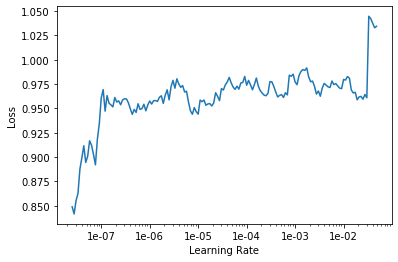

In [61]:
learn.lr_find(start_lr=1e-8, end_lr=0.1, num_it=200, stop_div=True)
learn.recorder.plot()

In [ ]:
learn.fit_one_cycle(10, max_lr=1e-3, callbacks=[SaveModelCallback(learn, every='improvement', mode='min',
                                                                  monitor='GroupMeanLogMAE',  name='mpnn1')])

epoch,train_loss,valid_loss,mean_absolute_error,GroupMeanLogMAE,time
0,0.138040,0.134346,0.095290,1.220695,12:14


Better model found at epoch 0 with GroupMeanLogMAE value: 1.2206945633075212.


In [86]:
learn.fit_one_cycle(10, max_lr=1e-4, callbacks=[SaveModelCallback(learn, every='improvement', mode='min',
                                                                  monitor='GroupMeanLogMAE',  name='mpnn2')])

epoch,train_loss,valid_loss,mean_absolute_error,GroupMeanLogMAE,time
0,0.043967,0.047556,0.033247,0.117283,25:25
1,0.046034,0.047675,0.033409,0.115949,27:11


Better model found at epoch 0 with GroupMeanLogMAE value: 0.11728293677794015.
Better model found at epoch 1 with GroupMeanLogMAE value: 0.11594874821080375.


Traceback (most recent call last):
  File "/anaconda2/envs/python36/lib/python3.6/multiprocessing/queues.py", line 240, in _feed
    send_bytes(obj)
  File "/anaconda2/envs/python36/lib/python3.6/multiprocessing/connection.py", line 200, in send_bytes
    self._send_bytes(m[offset:offset + size])
  File "/anaconda2/envs/python36/lib/python3.6/multiprocessing/connection.py", line 404, in _send_bytes
    self._send(header + buf)
  File "/anaconda2/envs/python36/lib/python3.6/multiprocessing/connection.py", line 368, in _send
    n = write(self._handle, buf)
BrokenPipeError: [Errno 32] Broken pipe
Traceback (most recent call last):
  File "/anaconda2/envs/python36/lib/python3.6/multiprocessing/queues.py", line 240, in _feed
    send_bytes(obj)
  File "/anaconda2/envs/python36/lib/python3.6/multiprocessing/connection.py", line 200, in send_bytes
    self._send_bytes(m[offset:offset + size])
  File "/anaconda2/envs/python36/lib/python3.6/multiprocessing/connection.py", line 404, in _send_by

KeyboardInterrupt: 

In [ ]:
learn.fit_one_cycle(10, max_lr=2e-5, callbacks=[SaveModelCallback(learn, every='improvement', mode='min',
                                                                  monitor='GroupMeanLogMAE',  name='mpnn3')])

In [ ]:
learn.fit_one_cycle(10, max_lr=4e-6, callbacks=[SaveModelCallback(learn, every='improvement', mode='min',
                                                                  monitor='GroupMeanLogMAE',  name='mpnn4')])

In [76]:
pred, _ = learn.get_preds()
pred_test, _ = learn.get_preds(DatasetType.Test)

RuntimeError: Expected object of backend CUDA but got backend CPU for argument #3 'index'